In [1]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import xroms
# from cartopy import geodesic  # FS only way to get this module
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import numpy as np
import cmocean.cm as cmo
from xgcm import Grid
import cmocean.cm as cmo
import matplotlib.gridspec as gridspec

In [2]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=3)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
def load_roms():
    # A basic chunk choice
    chunks = {'ocean_time': 10}
    glb_files = glob('/g/data/fu5/deg581/SA_model/ocean_his_garkgw_2018_full.nc')
    ds = xr.open_mfdataset(glb_files, chunks=chunks, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right')
    print('Loading data: OK!')
    return ds




def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def rho_eos(Tt,Ts,z_r):
    #     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # %
    # % function [rho,bvf]=rho_eos(Tt,Ts,z_r)
    # %
    # % Computes density via Equation Of State (EOS) for seawater.
    # % If so prescribed, non-linear EOS of Jackett and McDougall (1995)
    # % is used.
    # %
    # % Tt potential temperature [deg Celsius].
    # % Ts salinity [PSU].
    # % Tz pressure/depth, [depth in meters and negative].
    # %
    # % K0, K1 and K2 are the pressure polynomial coefficients for secant
    # % bulk modulus, so that
    # %
    # %               bulk = K0 - K1 * z + K2 * z**2 ;
    # %
    # % while rho1 is sea-water density [kg/m^3] at standard pressure
    # % of 1 Atm, so that the density anomaly at in-sity pressure is
    # %
    # %               rho = rho1 / (1 + z / bulk) - 1000
    # %
    # %  Reference:
    # %
    # %  Jackett, D. R. and T. J. McDougall, 1995, Minimal Adjustment of
    # %  Hydrostatic Profiles to Achieve Static Stability, Journ of Atmos.
    # %  and Oceanic Techn., vol. 12, pp. 381-389.
    # %
    # % << This equation of state formulation has been derived by Jackett
    # %    and McDougall (1992), unpublished manuscript, CSIRO, Australia.
    # %    It computes in-situ density anomaly as a function of potential
    # %    temperature (Celsius) relative to the surface, salinity (PSU),
    # %    and depth (meters).  It assumes  no  pressure  variation along
    # %    geopotential  surfaces,  that  is,  depth  and  pressure  are
    # %    interchangeable. >>
    # %                                          John Wilkin, 29 July 92
    # %
    # % Check Values: T=3 C S=35.5 PSU Z=-5000 m rho=1050.3639165364 
    
    import numpy as np
    
    A00=+19092.56;A01=+209.8925;
    A02=-3.041638;A03=-1.852732e-3;A04=-1.361629e-5;A10=104.4077;
    A11=-6.500517;A12=+0.1553190;A13=2.326469e-4;AS0=-5.587545;
    AS1=+0.7390729;AS2=-1.909078e-2;B00=+4.721788e-1;B01=+1.028859e-2;
    B02=-2.512549e-4;B03=-5.939910e-7;B10=-1.571896e-2;B11=-2.598241e-4;
    B12=+7.267926e-6;BS1=+2.042967e-3;E00=+1.045941e-5;E01=-5.782165e-10;
    E02=+1.296821e-7;E10=-2.595994e-7;E11=-1.248266e-9;E12=-3.508914e-9;

    QR=+999.842594;Q01=+6.793952e-2;Q02=-9.095290e-3;
    Q03=+1.001685e-4;Q04=-1.120083e-6;Q05=+6.536332e-9;Q10=+0.824493;
    Q11=-4.08990e-3;Q12=+7.64380e-5;Q13=-8.24670e-7;Q14=+5.38750e-9;
    QS0=-5.72466e-3;QS1=+1.02270e-4;QS2=-1.65460e-6;Q20=+4.8314e-4;
    
    
    sqrtTs=np.sqrt(Ts);

    K0=A00+Tt*(A01+Tt*(A02+Tt*(A03+Tt*A04)))+Ts*(A10+Tt*(A11+Tt*(A12+Tt*A13))+sqrtTs*(AS0+Tt*(AS1+Tt*AS2)));
    K1=B00+Tt*(B01+Tt*(B02+Tt*B03))+Ts*(B10+Tt*(B11+Tt*B12)+sqrtTs*BS1);
    K2=E00+Tt*(E01+Tt*E02)+Ts*(E10+Tt*(E11+Tt*E12));
    rho1=QR+Tt*(Q01+Tt*(Q02+Tt*(Q03+Tt*(Q04+Tt*Q05))))+Ts*(Q10+Tt*(Q11+Tt*(Q12+Tt*(Q13+Tt*Q14)))+sqrtTs*(QS0+Tt*(QS1+Tt*QS2))+Ts*Q20);
    rho=rho1/(1+0.1*z_r/(K0-z_r*(K1-z_r*K2)));
    
    return rho


#### load data, make grid file, correct vertical coordinate


In [4]:
from pathlib import Path
my_file = Path("/g/data/fu5/deg581/SA_model/ocean_his_garkgw_2018_full_daymean.nc")
if my_file.exists():
    print('already exists')
else:
    # make daily means because hourly data is unnecessary
    !module load cdo; cdo -v daymean /g/data/fu5/deg581/SA_model/ocean_his_garkgw_2018_full.nc /g/data/fu5/deg581/SA_model/ocean_his_garkgw_2018_full_daymean.nc

already exists


In [5]:
# correct calendar in SA roms file
ds = xr.open_dataset('/g/data/fu5/deg581/SA_model/ocean_his_garkgw_2018_full_daymean.nc', decode_times=False)
ds.ocean_time.attrs['calendar'] = 'proleptic_gregorian'
# ds.dstart.attrs['calendar'] = 'proleptic_gregorian'

ds = xr.decode_cf(ds, decode_times=True)

In [6]:
# add back in some variables
ds["Vtransform"]=2
ds["hc"]=20

In [7]:
# ds = load_roms()
ds = processROMSGrid(ds)
grid = makeROMSGridObject(ds)

In [8]:
ds

<xarray.Dataset>
Dimensions:          (ocean_time: 365, bnds: 2, eta_rho: 263, xi_rho: 227, xi_u: 226, eta_v: 262, s_rho: 15, s_w: 16, tracer: 2, boundary: 4)
Coordinates: (12/14)
  * ocean_time       (ocean_time) datetime64[ns] 2018-01-01T11:30:00 ... 2018...
    lon_rho          (eta_rho, xi_rho) float64 135.1 135.1 135.1 ... 140.5 140.5
    lat_rho          (eta_rho, xi_rho) float64 -35.16 -35.17 ... -33.8 -33.81
    lon_u            (eta_rho, xi_u) float64 ...
    lat_u            (eta_rho, xi_u) float64 ...
    lon_v            (eta_v, xi_rho) float64 ...
    ...               ...
    lat_psi          (eta_v, xi_u) float64 ...
  * s_rho            (s_rho) float64 -0.9667 -0.9 -0.8333 ... -0.1 -0.03333
  * s_w              (s_w) float64 -1.0 -0.9333 -0.8667 ... -0.1333 -0.06667 0.0
    z_w              (ocean_time, s_w, eta_rho, xi_rho) float64 -115.0 ... 0.0
    z_rho            (ocean_time, s_rho, eta_rho, xi_rho) float64 -111.6 ... 0.0
    z_rho0           (eta_rho, xi_rho, s_rho) float64 -111.6 -98.54 ... nan nan
Dimensions without coordinates: bnds, eta_rho, xi_rho, xi_u, eta_v, tracer, boundary
Data variables: (12/61)
    ocean_time_bnds  (ocean_time, bnds) datetime64[ns] ...
    nl_tnu2          (tracer) float64 ...
    LtracerSponge    (tracer) int32 ...
    Akt_bak          (tracer) float64 ...
    Tnudg            (tracer) float64 ...
    FSobc_in         (boundary) float64 ...
    ...               ...
    dz_w             (ocean_time, s_w, eta_rho, xi_rho) float64 -111.6 ... 0.0
    dz_u             (ocean_time, s_rho, eta_rho, xi_u) float64 8.887 ... 0.0
    dz_w_u           (ocean_time, s_w, eta_rho, xi_u) float64 -111.7 ... 0.0
    dz_v             (ocean_time, s_rho, eta_v, xi_rho) float64 8.853 ... 0.0
    dz_w_v           (ocean_time, s_w, eta_v, xi_rho) float64 -111.3 ... 0.0
    dA               (eta_rho, xi_rho) float64 2.236e+06 2.236e+06 ... 2.269e+06
Attributes: (12/42)
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    history:           Thu Nov 17 15:57:23 2022: cdo -v daymean /g/data/fu5/d...
    Conventions:       CF-1.4, SGRID-0.3
    file:              ocean_his_garkgw_2018_full.nc
    format:            netCDF-4/HDF5 file
    type:              ROMS/TOMS history file
    ...                ...
    compiler_flags:    -frepack-arrays -O3 -ffast-math -ftree-vectorize -ftre...
    tiling:            004x004
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       TG5K_WAVES, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFL...
    frequency:         day
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...

In [11]:
ds = ds.drop_vars(['AKs','w','vbar','ubar','zeta','z_u','z_v','dz_w','dz_u','dz_w_u','dz_v','dz_w_v','dz','z_w'])

ds.load()

<xarray.Dataset>
Dimensions:          (ocean_time: 365, bnds: 2, eta_rho: 263, xi_rho: 227, xi_u: 226, eta_v: 262, s_rho: 15, s_w: 16, tracer: 2, boundary: 4)
Coordinates: (12/13)
  * ocean_time       (ocean_time) datetime64[ns] 2018-01-01T11:30:00 ... 2018...
    lon_rho          (eta_rho, xi_rho) float64 135.1 135.1 135.1 ... 140.5 140.5
    lat_rho          (eta_rho, xi_rho) float64 -35.16 -35.17 ... -33.8 -33.81
    lon_u            (eta_rho, xi_u) float64 135.1 135.1 135.1 ... 140.5 140.5
    lat_u            (eta_rho, xi_u) float64 -35.17 -35.17 ... -33.8 -33.8
    lon_v            (eta_v, xi_rho) float64 135.1 135.1 135.1 ... 140.5 140.5
    ...               ...
    lon_psi          (eta_v, xi_u) float64 135.1 135.1 135.1 ... 140.5 140.5
    lat_psi          (eta_v, xi_u) float64 -35.16 -35.17 -35.18 ... -33.8 -33.81
  * s_rho            (s_rho) float64 -0.9667 -0.9 -0.8333 ... -0.1 -0.03333
  * s_w              (s_w) float64 -1.0 -0.9333 -0.8667 ... -0.1333 -0.06667 0.0
    z_rho            (ocean_time, s_rho, eta_rho, xi_rho) float64 -111.6 ... 0.0
    z_rho0           (eta_rho, xi_rho, s_rho) float64 -111.6 -98.54 ... nan nan
Dimensions without coordinates: bnds, eta_rho, xi_rho, xi_u, eta_v, tracer, boundary
Data variables: (12/48)
    ocean_time_bnds  (ocean_time, bnds) datetime64[ns] 2018-01-01 ... 2018-12...
    nl_tnu2          (tracer) float64 2.0 2.0
    LtracerSponge    (tracer) int32 0 0
    Akt_bak          (tracer) float64 1e-06 1e-06
    Tnudg            (tracer) float64 0.04762 0.04762
    FSobc_in         (boundary) float64 0.0 0.0 0.0 0.0
    ...               ...
    dx_psi           (eta_v, xi_u) float64 1.503e+03 1.503e+03 ... 1.522e+03
    dy               (eta_rho, xi_rho) float64 1.488e+03 1.488e+03 ... 1.49e+03
    dy_u             (eta_rho, xi_u) float64 1.488e+03 1.488e+03 ... 1.49e+03
    dy_v             (eta_v, xi_rho) float64 1.488e+03 1.488e+03 ... 1.49e+03
    dy_psi           (eta_v, xi_u) float64 1.488e+03 1.488e+03 ... 1.49e+03
    dA               (eta_rho, xi_rho) float64 2.236e+06 2.236e+06 ... 2.269e+06
Attributes: (12/42)
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    history:           Thu Nov 17 15:57:23 2022: cdo -v daymean /g/data/fu5/d...
    Conventions:       CF-1.4, SGRID-0.3
    file:              ocean_his_garkgw_2018_full.nc
    format:            netCDF-4/HDF5 file
    type:              ROMS/TOMS history file
    ...                ...
    compiler_flags:    -frepack-arrays -O3 -ffast-math -ftree-vectorize -ftre...
    tiling:            004x004
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       TG5K_WAVES, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFL...
    frequency:         day
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...

#### Simple plots of domain

Text(0.5, 1.0, '')

<Figure size 432x288 with 0 Axes>

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/shapefile.py:391: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


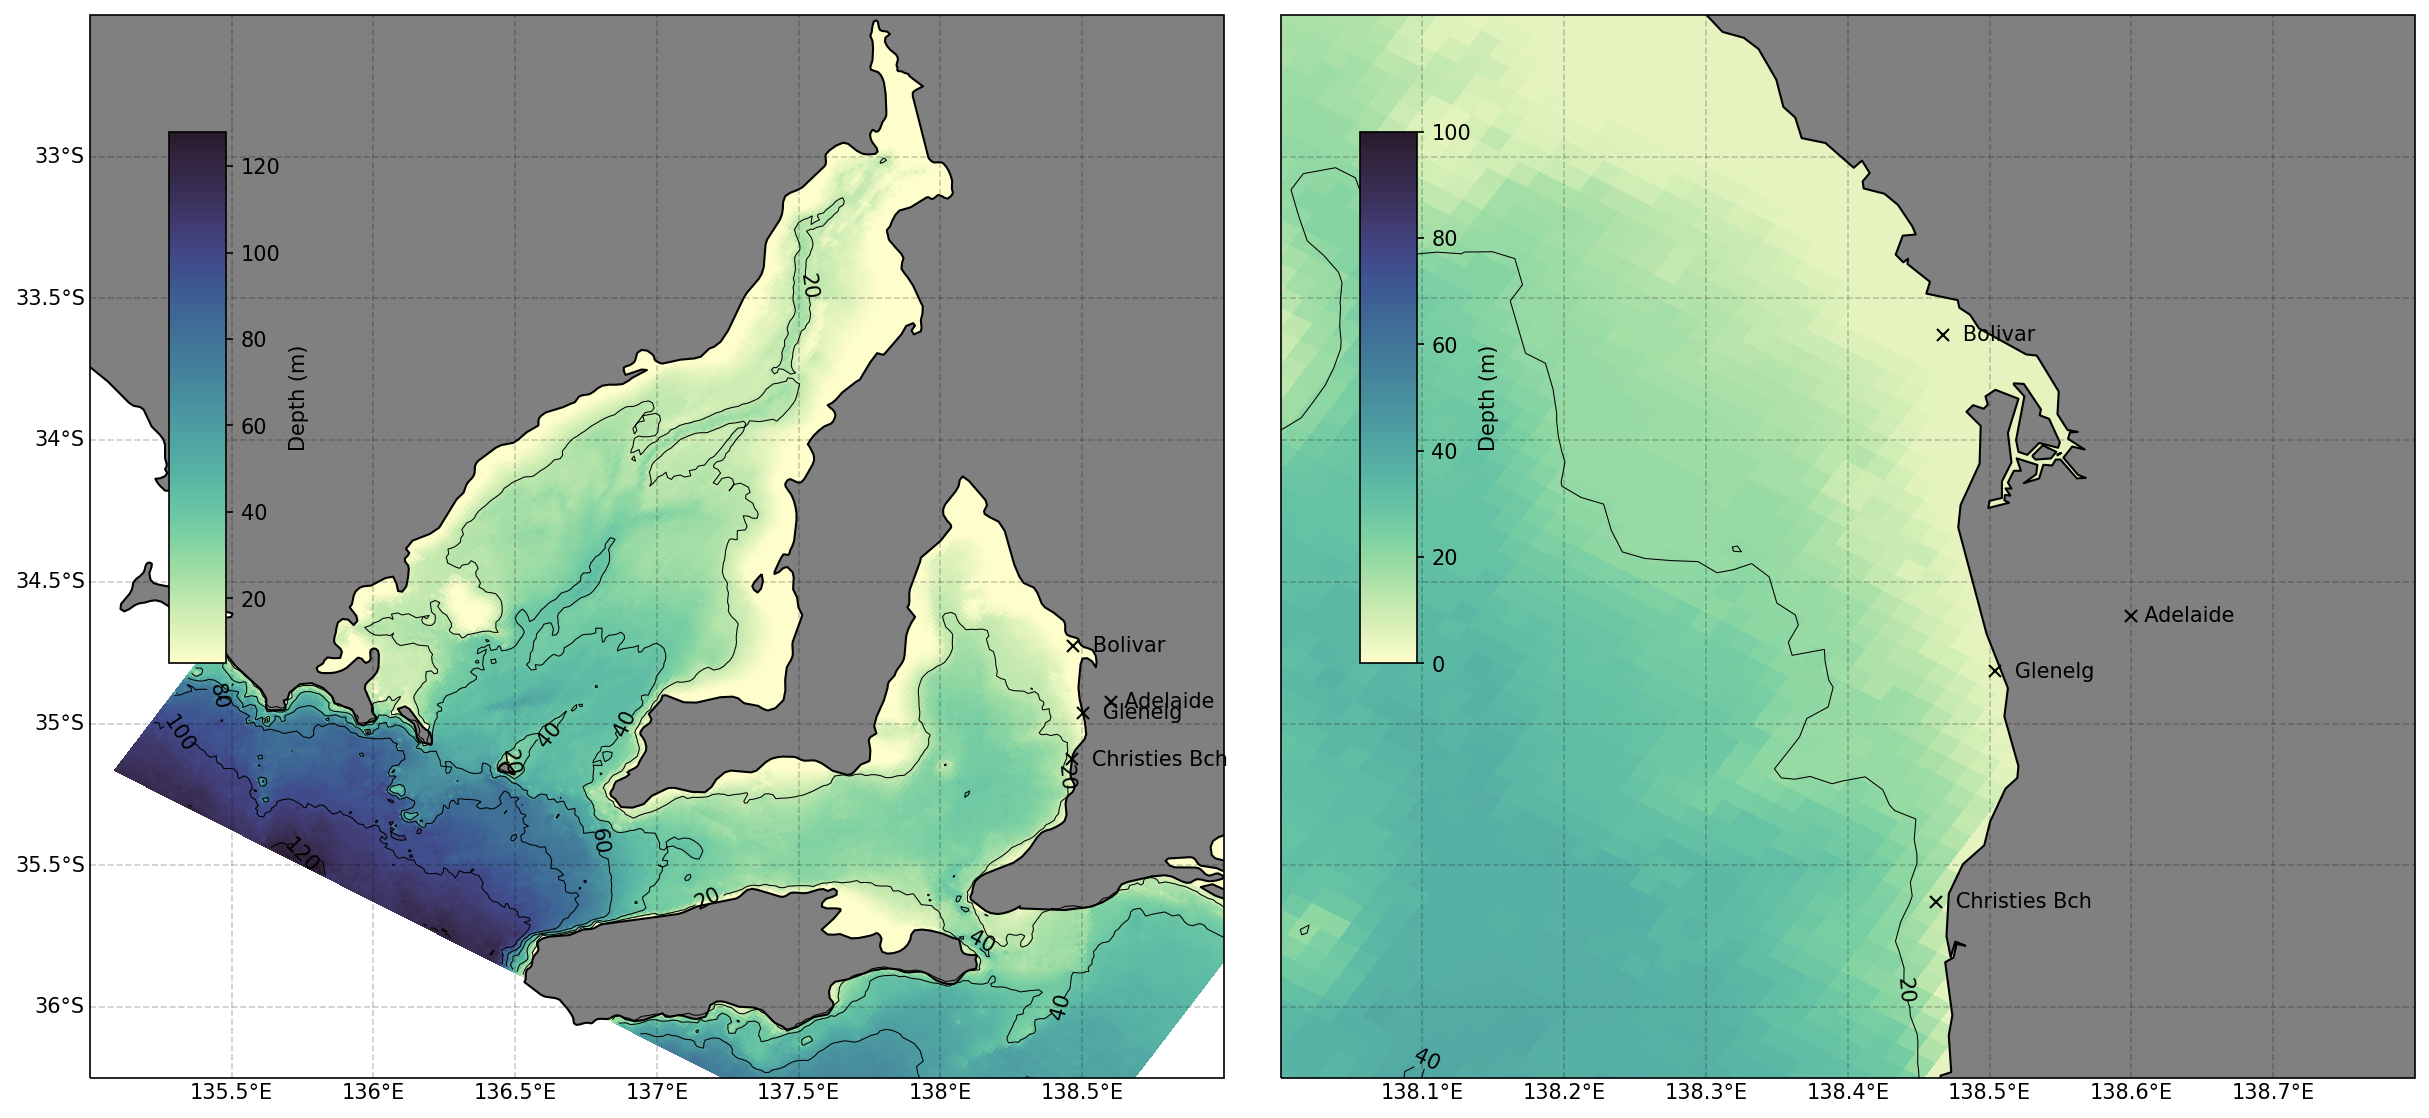

In [12]:
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
coastHR = cfeature.GSHHSFeature(scale='auto')

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,20],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([135, 139, -36.25, -32.5])
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im = ds.h.plot(x='lon_rho',y='lat_rho',cmap='cmo.deep', add_colorbar=False)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.5,levels=np.arange(0,140,20))
ax.clabel(co, co.levels, inline=True, fontsize=10)


ax.text(138.600,-34.9242,'  Adelaide  ',ha='left',va='center'), ax.plot(138.600,-34.9242,marker='x',color='k')
ax.text(138.4674,-34.72596,'   Bolivar  ',ha='left',va='center'), ax.plot(138.4674,-34.72596,marker='x',color='k')
ax.text(138.50393,-34.96313,'   Glenelg  ',ha='left',va='center'), ax.plot(138.50393,-34.96313,marker='x',color='k')
ax.text(138.462347,-35.12587,'   Christies Bch  ',ha='left',va='center'), ax.plot(138.462347,-35.12587,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax.set_title('')  

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax.set_extent([138, 138.8, -35.25, -34.5])
feature = ax.add_feature(coastHR, edgecolor='black',facecolor='gray')
im = ds.h.plot(x='lon_rho',y='lat_rho',cmap='cmo.deep', add_colorbar=False,vmin=0,vmax=100)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.5,levels=np.arange(0,140,20))
ax.clabel(co, co.levels, inline=True, fontsize=10)

ax.text(138.600,-34.9242,'  Adelaide  ',ha='left',va='center'), ax.plot(138.600,-34.9242,marker='x',color='k')
ax.text(138.4674,-34.72596,'   Bolivar  ',ha='left',va='center'), ax.plot(138.4674,-34.72596,marker='x',color='k')
ax.text(138.50393,-34.96313,'   Glenelg  ',ha='left',va='center'), ax.plot(138.50393,-34.96313,marker='x',color='k')
ax.text(138.462347,-35.12587,'   Christies Bch  ',ha='left',va='center'), ax.plot(138.462347,-35.12587,marker='x',color='k')
# ax.text(151.212333,-34.043083,'   Cronulla  ',ha='left',va='center'), ax.plot(151.212333,-34.043083,marker='x',color='k')
# ax.text(150.87365,-34.563683,'   Shellharbour  ',ha='left',va='center'), ax.plot(150.87365,-34.563683,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax.set_title('')  


#### Calculate the velocity magnitude

In [13]:
ds["vmag"] = (('ocean_time','s_rho','eta_rho','xi_rho'),((grid.interp(ds.u,'X',boundary='fill')**2+grid.interp(ds.v,'Y',boundary='fill')**2)**0.5).values)

Text(0.5, 1.0, '')

<Figure size 432x288 with 0 Axes>

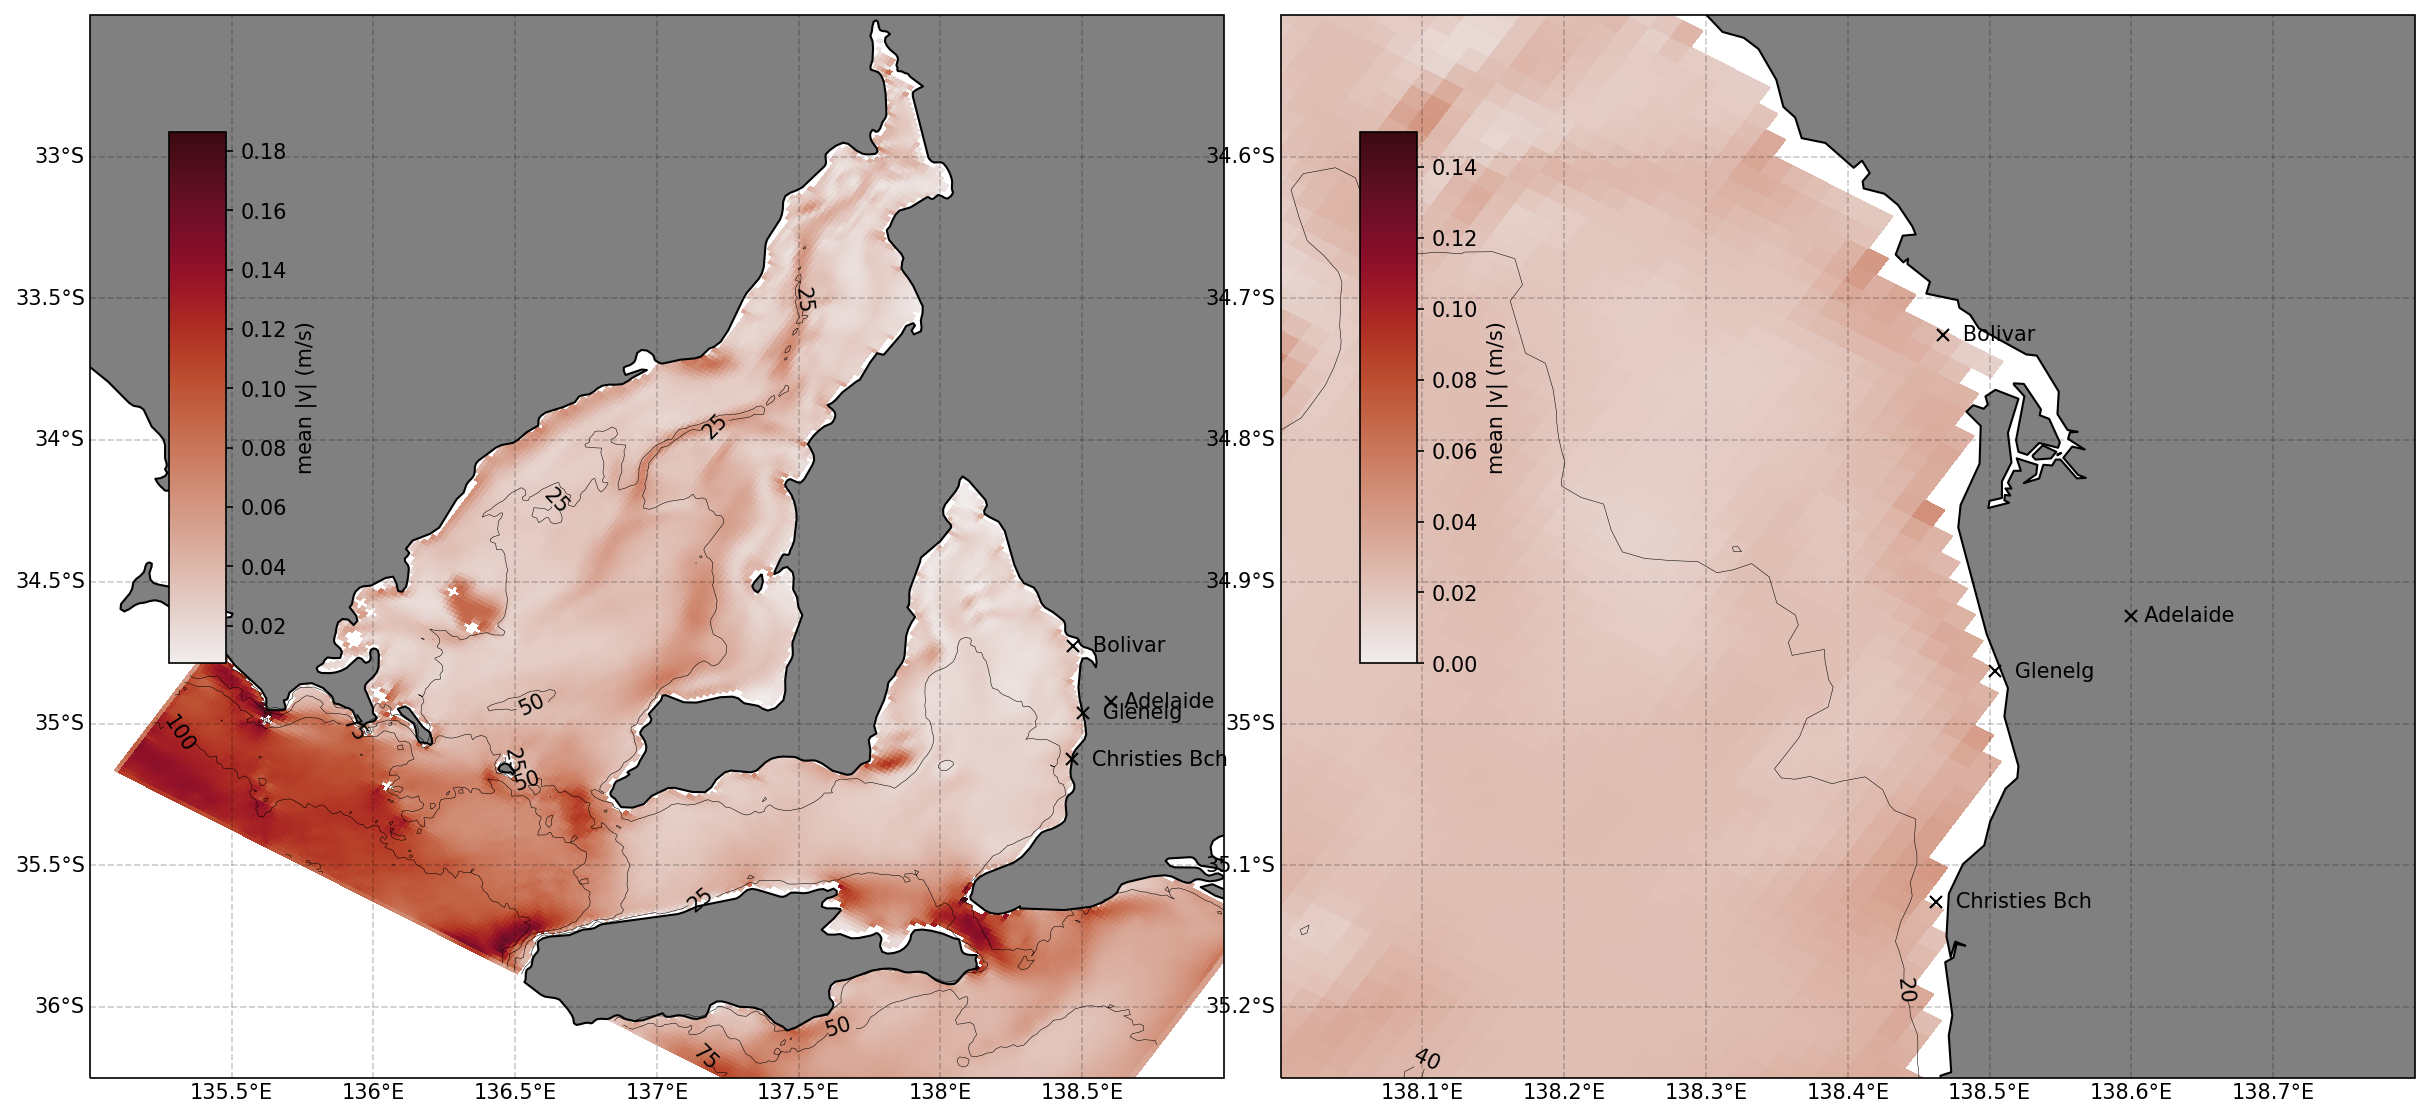

In [36]:


gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,20],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([135, 139, -36.25, -32.5])
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im = ds.vmag.isel(s_rho=0).mean(dim='ocean_time').plot(x='lon_rho',y='lat_rho',cmap='cmo.amp', add_colorbar=False)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)


ax.text(138.600,-34.9242,'  Adelaide  ',ha='left',va='center'), ax.plot(138.600,-34.9242,marker='x',color='k')
ax.text(138.4674,-34.72596,'   Bolivar  ',ha='left',va='center'), ax.plot(138.4674,-34.72596,marker='x',color='k')
ax.text(138.50393,-34.96313,'   Glenelg  ',ha='left',va='center'), ax.plot(138.50393,-34.96313,marker='x',color='k')
ax.text(138.462347,-35.12587,'   Christies Bch  ',ha='left',va='center'), ax.plot(138.462347,-35.12587,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('mean |v| (m/s)')
ax.set_title('')  

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax.set_extent([138, 138.8, -35.25, -34.5])
feature = ax.add_feature(coastHR, edgecolor='black',facecolor='gray')
im = ds.vmag.isel(s_rho=0).mean(dim='ocean_time').plot(x='lon_rho',y='lat_rho',cmap='cmo.amp', add_colorbar=False,vmin=0,vmax=.15)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=np.arange(0,220,20),linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)


ax.text(138.600,-34.9242,'  Adelaide  ',ha='left',va='center'), ax.plot(138.600,-34.9242,marker='x',color='k')
ax.text(138.4674,-34.72596,'   Bolivar  ',ha='left',va='center'), ax.plot(138.4674,-34.72596,marker='x',color='k')
ax.text(138.50393,-34.96313,'   Glenelg  ',ha='left',va='center'), ax.plot(138.50393,-34.96313,marker='x',color='k')
ax.text(138.462347,-35.12587,'   Christies Bch  ',ha='left',va='center'), ax.plot(138.462347,-35.12587,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('mean |v| (m/s)')
ax.set_title('')  


#### now some time vs. profiles at a chosen location

In [15]:
# ds["rho"] = rho_eos(ds.temp,ds.salt,ds.z_rho)
# 
# rho = rho_eos(ds.temp.isel

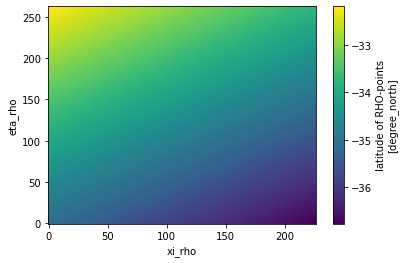

In [88]:
ds.lat_rho.plot()

155
134


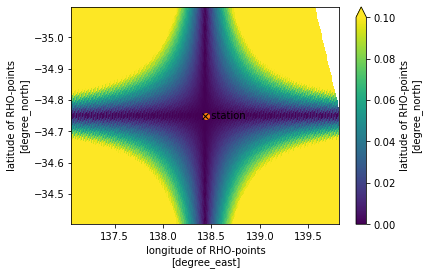

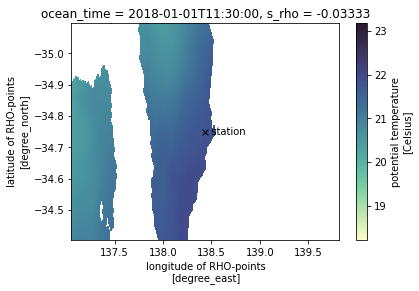

In [93]:
#close to bolivar
station_lon = 138.437227
station_lat = -34.75#-34.755964

closest_approach = (np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).argmin(dim=['eta_rho','xi_rho'])
eta_station = closest_approach['eta_rho'].values
xi_station = closest_approach['xi_rho'].values

print(xi_station)
print(eta_station)

(np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).plot(x='lon_rho',y='lat_rho',vmin=0,vmax=.1)
plt.plot(ds.lon_rho.isel(eta_rho=eta_station,xi_rho=xi_station),ds.lat_rho.isel(eta_rho=eta_station,xi_rho=xi_station),marker='o',color='C1')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()

ds.temp.isel(ocean_time=0,s_rho=-1).plot(x='lon_rho',y='lat_rho',cmap='cmo.deep')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()


In [94]:
rho = rho_eos(ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station),ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station),ds.z_rho.isel(eta_rho=eta_station,xi_rho=xi_station))

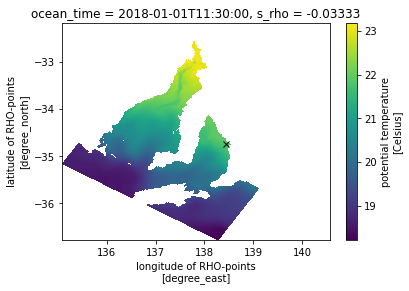

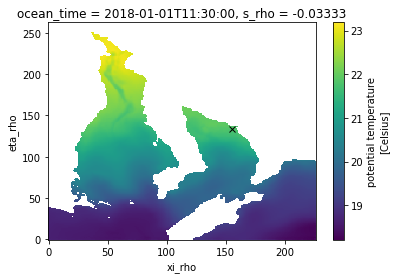

In [95]:
ds.temp.isel(s_rho=-1,ocean_time=0).plot(x='lon_rho',y='lat_rho')
plt.plot(station_lon,station_lat,marker='x',color='k')
# plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
# plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()

ds.temp.isel(s_rho=-1,ocean_time=0).plot()
plt.plot(xi_station,eta_station,marker='x',color='k')
# plt.xlim([160,180])
# plt.ylim([130,150])


In [96]:
ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station)

<xarray.DataArray 'temp' (ocean_time: 365, s_rho: 15)>
array([[21.79542 , 21.794659, 21.794136, ..., 21.800703, 21.799461,
        21.80151 ],
       [21.618912, 21.618858, 21.6188  , ..., 21.625673, 21.623928,
        21.626232],
       [21.819124, 21.818142, 21.81761 , ..., 21.83752 , 21.841154,
        21.836594],
       ...,
       [23.249243, 23.247562, 23.24755 , ..., 23.256346, 23.255886,
        23.257425],
       [23.213089, 23.210909, 23.210665, ..., 23.217045, 23.215794,
        23.218111],
       [23.291136, 23.290741, 23.289082, ..., 23.295078, 23.297106,
        23.290554]], dtype=float32)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2018-01-01T11:30:00 ... 2018-12-3...
    lon_rho     float64 138.4
    lat_rho     float64 -34.75
  * s_rho       (s_rho) float64 -0.9667 -0.9 -0.8333 ... -0.1667 -0.1 -0.03333
    z_rho       (ocean_time, s_rho) float64 -6.767 -6.183 ... -0.4521 -0.1012
    z_rho0      (s_rho) float64 -6.769 -6.19 -5.49 ... -0.727 -0.3698 -0.01456
Attributes:
    long_name:     potential temperature
    units:         Celsius
    cell_methods:  ocean_time: mean
    time:          ocean_time
    grid:          grid
    location:      face
    field:         temperature, scalar, series

Text(0.5, 1.0, 'Velocity magnitude (m/s)')

<Figure size 432x288 with 0 Axes>

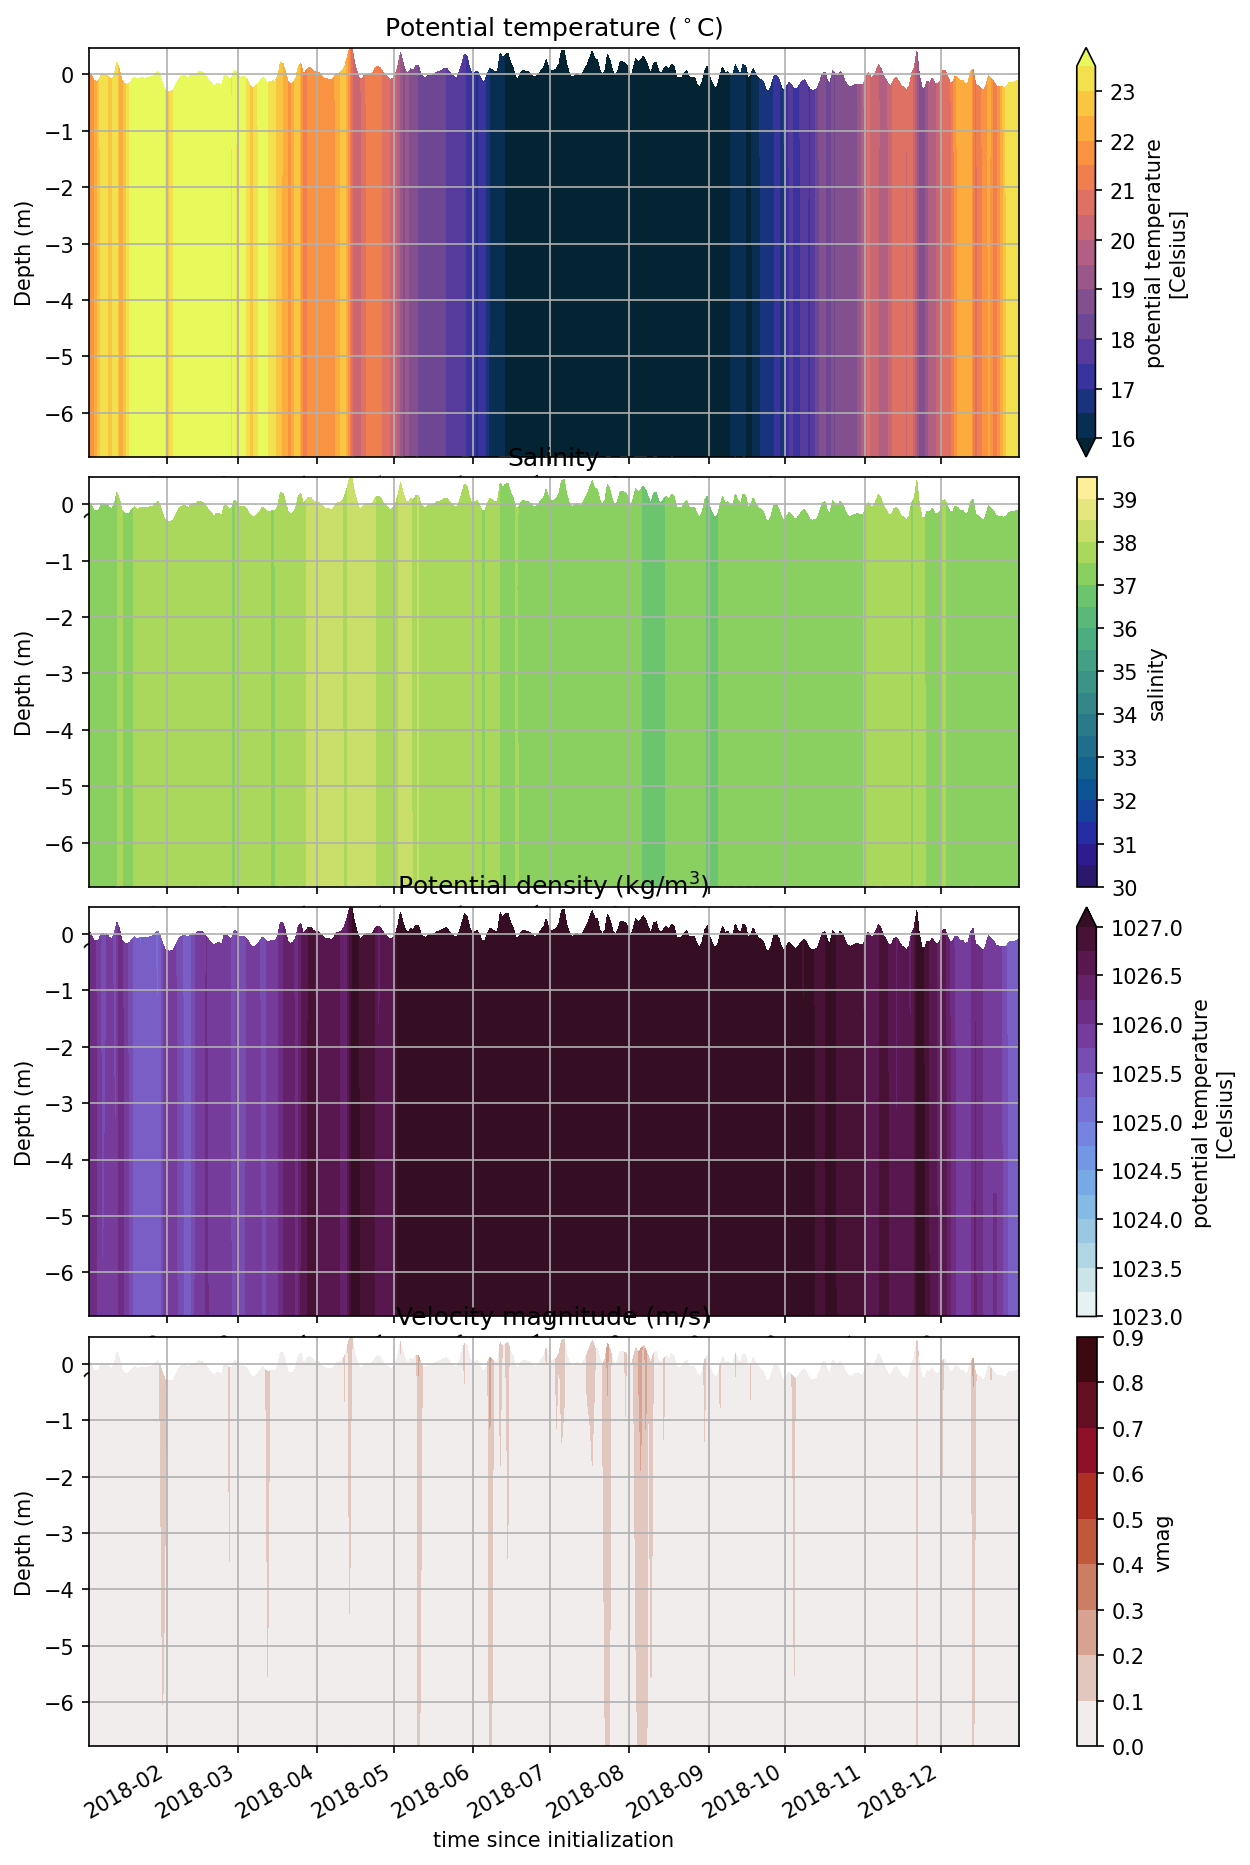

In [97]:
gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,15],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0])
ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.thermal',levels=np.arange(16,24,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential temperature ($^\circ$C)')

ax = fig.add_subplot(gs[1,0])
ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.haline',levels=np.arange(30,40,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Salinity')

ax = fig.add_subplot(gs[2,0])
rho.plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.dense',levels=np.arange(1023,1027.25,.25))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential density (kg/m$^{3}$)')

ax = fig.add_subplot(gs[3,0])
ds.vmag.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.amp',levels=np.arange(0,1,.1))

ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Velocity magnitude (m/s)')

170
110


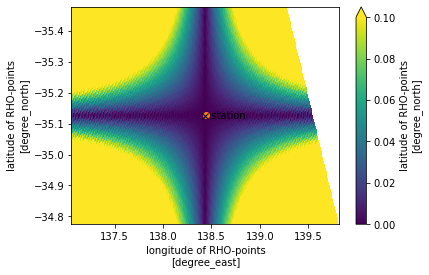

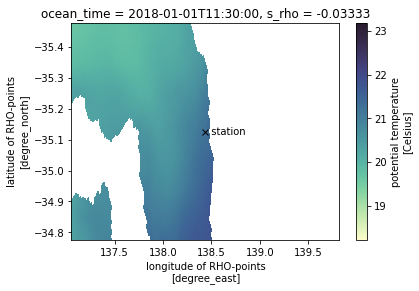

In [98]:
#close to Christies Beach
station_lon = 138.437227
station_lat = -35.12587

closest_approach = (np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).argmin(dim=['eta_rho','xi_rho'])
eta_station = closest_approach['eta_rho'].values
xi_station = closest_approach['xi_rho'].values

print(xi_station)
print(eta_station)

(np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).plot(x='lon_rho',y='lat_rho',vmin=0,vmax=.1)
plt.plot(ds.lon_rho.isel(eta_rho=eta_station,xi_rho=xi_station),ds.lat_rho.isel(eta_rho=eta_station,xi_rho=xi_station),marker='o',color='C1')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()

ds.temp.isel(ocean_time=0,s_rho=-1).plot(x='lon_rho',y='lat_rho',cmap='cmo.deep')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()


In [100]:
rho = rho_eos(ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station),ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station),ds.z_rho.isel(eta_rho=eta_station,xi_rho=xi_station))

Text(0.5, 1.0, 'Velocity magnitude (m/s)')

<Figure size 432x288 with 0 Axes>

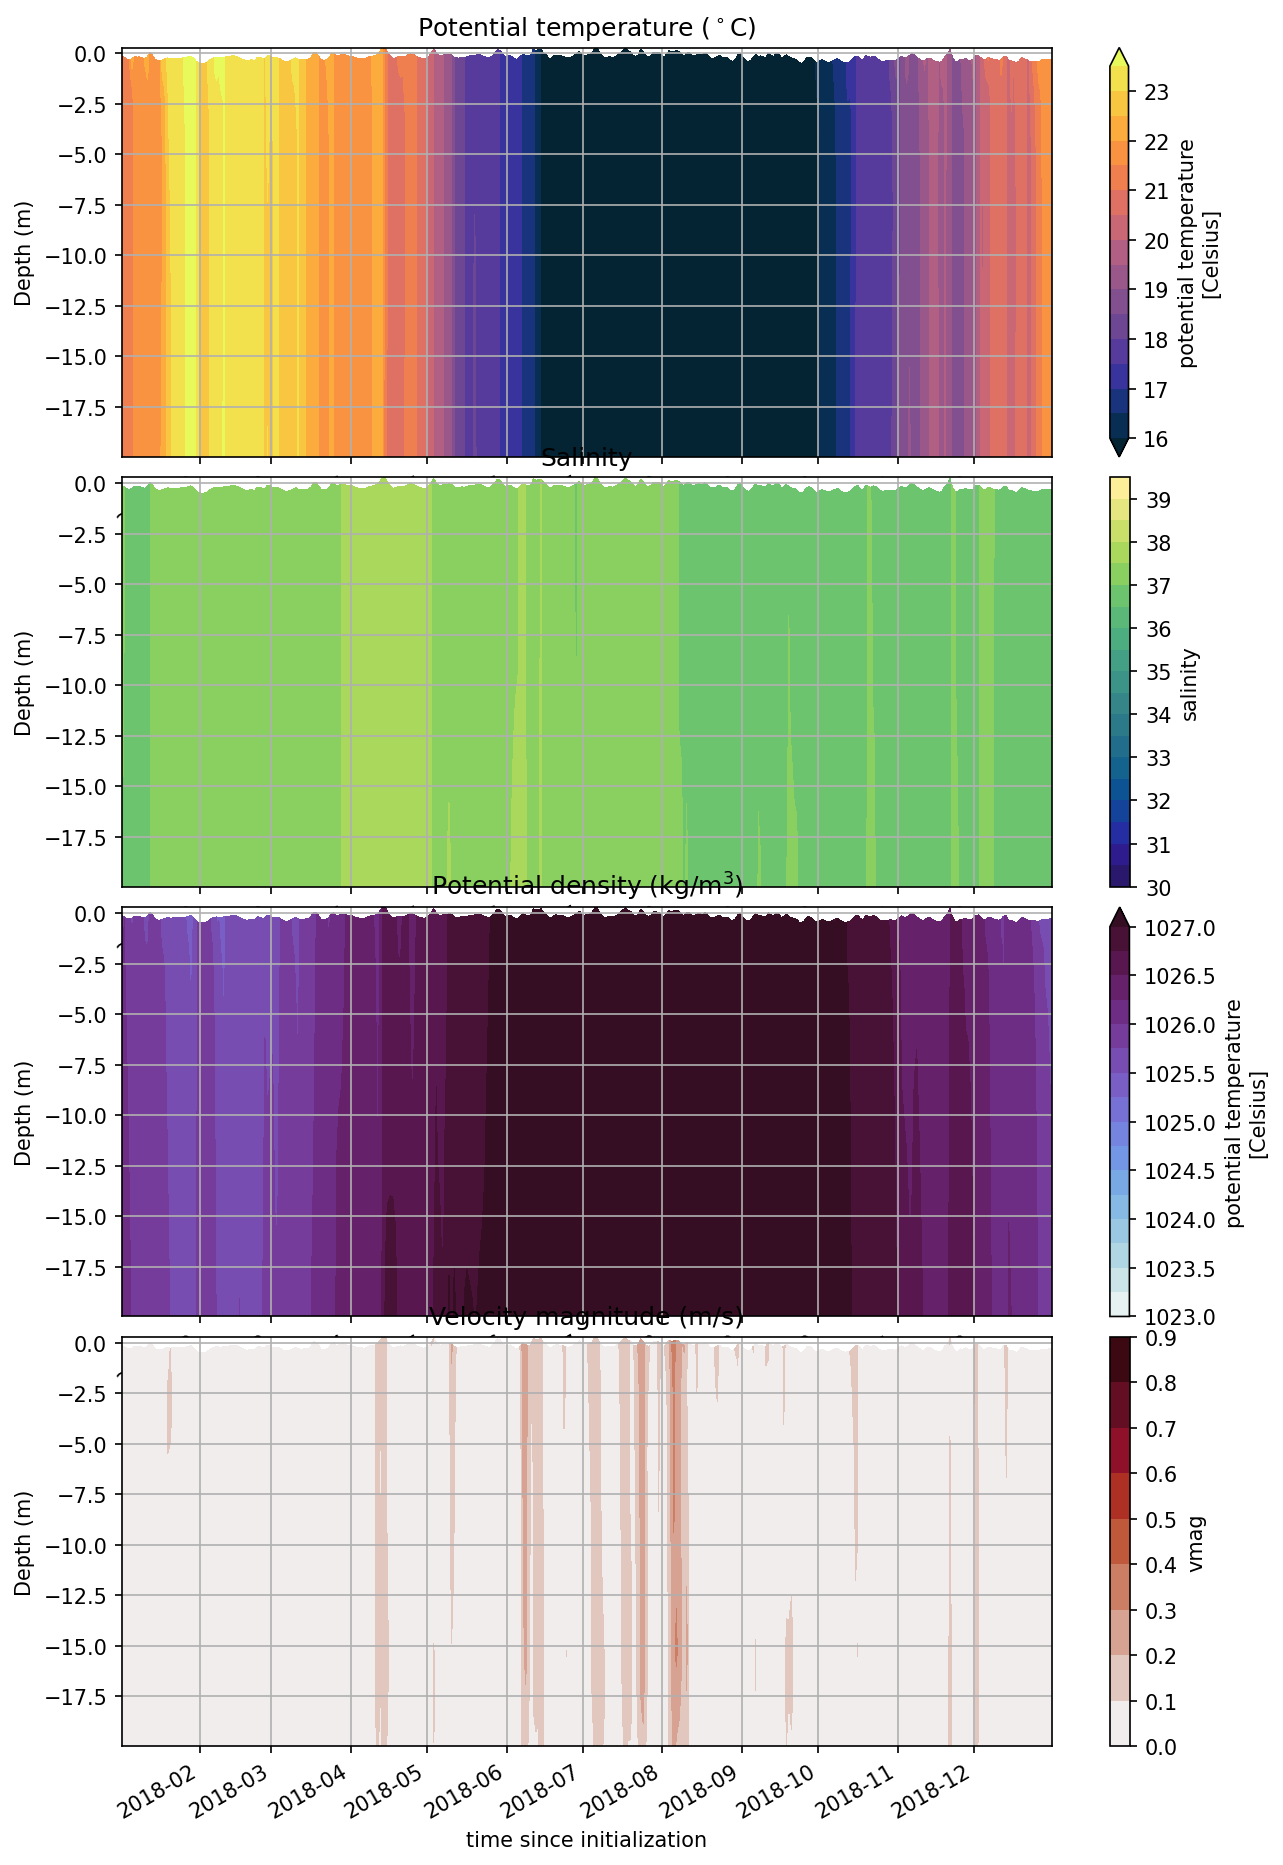

In [101]:
gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,15],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0])
ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.thermal',levels=np.arange(16,24,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential temperature ($^\circ$C)')

ax = fig.add_subplot(gs[1,0])
ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.haline',levels=np.arange(30,40,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Salinity')

ax = fig.add_subplot(gs[2,0])
rho.plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.dense',levels=np.arange(1023,1027.25,.25))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential density (kg/m$^{3}$)')

ax = fig.add_subplot(gs[3,0])
ds.vmag.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.amp',levels=np.arange(0,1,.1))

ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Velocity magnitude (m/s)')

165
107


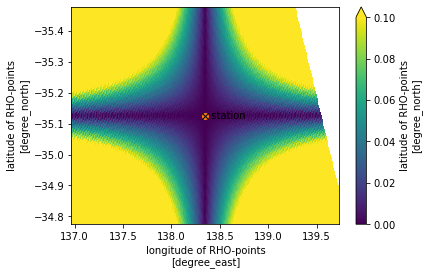

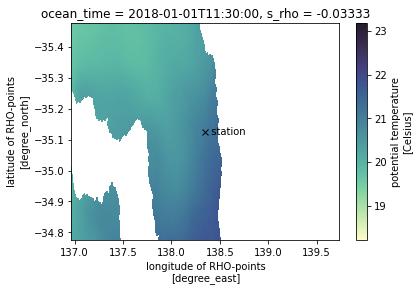

In [102]:
#close to Christies Beach
station_lon = 138.35
station_lat = -35.12587

closest_approach = (np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).argmin(dim=['eta_rho','xi_rho'])
eta_station = closest_approach['eta_rho'].values
xi_station = closest_approach['xi_rho'].values

print(xi_station)
print(eta_station)

(np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).plot(x='lon_rho',y='lat_rho',vmin=0,vmax=.1)
plt.plot(ds.lon_rho.isel(eta_rho=eta_station,xi_rho=xi_station),ds.lat_rho.isel(eta_rho=eta_station,xi_rho=xi_station),marker='o',color='C1')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()

ds.temp.isel(ocean_time=0,s_rho=-1).plot(x='lon_rho',y='lat_rho',cmap='cmo.deep')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()


In [104]:
rho = rho_eos(ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station),ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station),ds.z_rho.isel(eta_rho=eta_station,xi_rho=xi_station))

Text(0.5, 1.0, 'Velocity magnitude (m/s)')

<Figure size 432x288 with 0 Axes>

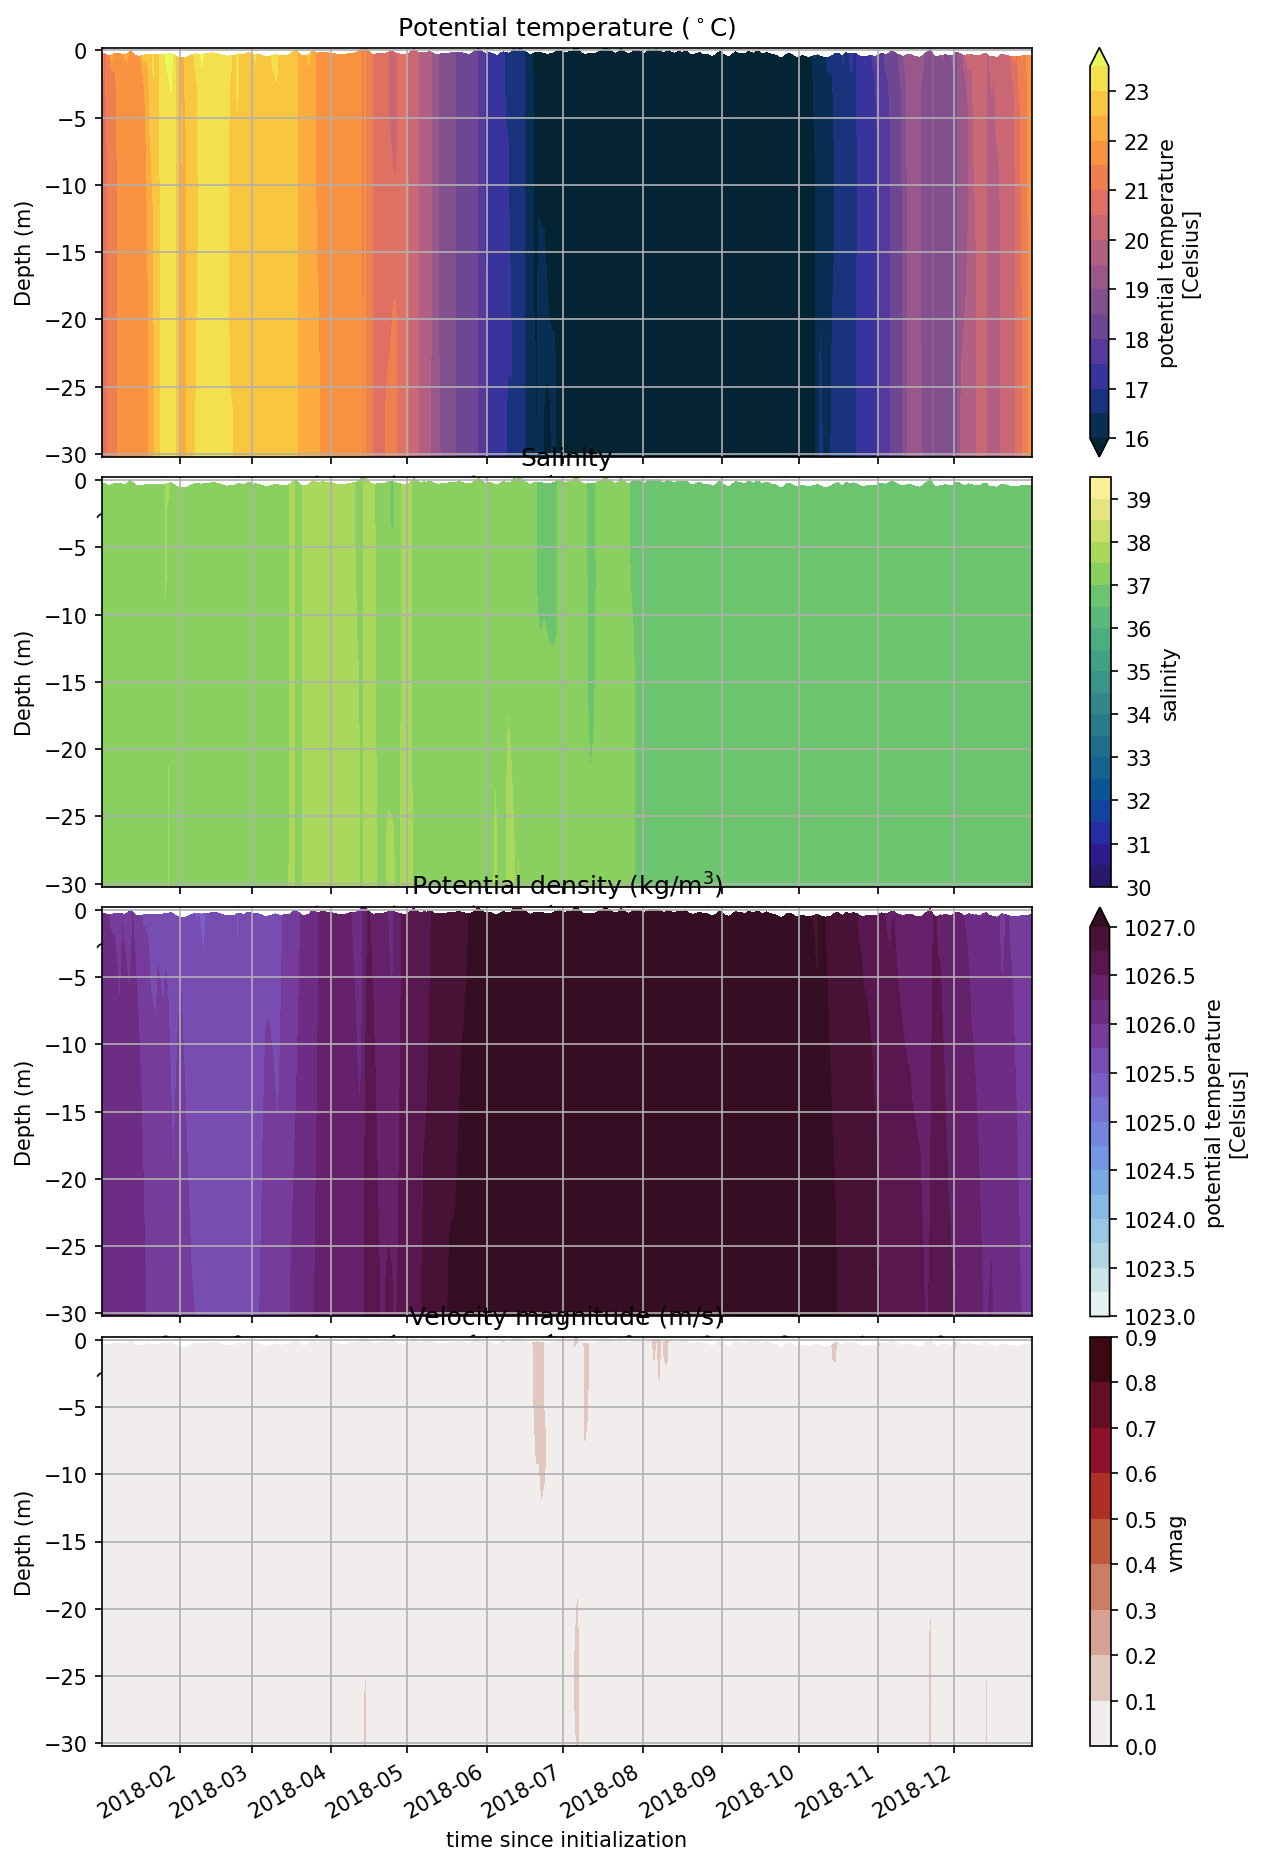

In [105]:
gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,15],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0])
ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.thermal',levels=np.arange(16,24,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential temperature ($^\circ$C)')

ax = fig.add_subplot(gs[1,0])
ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.haline',levels=np.arange(30,40,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Salinity')

ax = fig.add_subplot(gs[2,0])
rho.plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.dense',levels=np.arange(1023,1027.25,.25))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential density (kg/m$^{3}$)')

ax = fig.add_subplot(gs[3,0])
ds.vmag.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.amp',levels=np.arange(0,1,.1))

ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Velocity magnitude (m/s)')

50
23


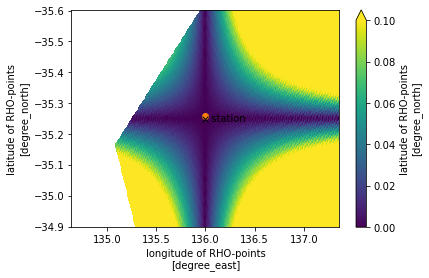

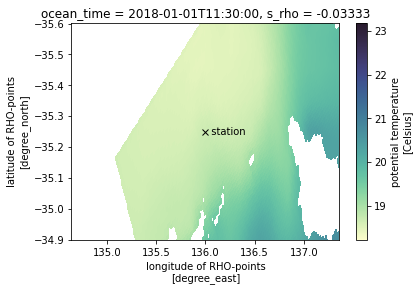

In [106]:
#close to Christies Beach
station_lon = 136
station_lat = -35.25

closest_approach = (np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).argmin(dim=['eta_rho','xi_rho'])
eta_station = closest_approach['eta_rho'].values
xi_station = closest_approach['xi_rho'].values

print(xi_station)
print(eta_station)

(np.abs((ds.lat_rho - station_lat)*(ds.lon_rho - station_lon))).plot(x='lon_rho',y='lat_rho',vmin=0,vmax=.1)
plt.plot(ds.lon_rho.isel(eta_rho=eta_station,xi_rho=xi_station),ds.lat_rho.isel(eta_rho=eta_station,xi_rho=xi_station),marker='o',color='C1')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()

ds.temp.isel(ocean_time=0,s_rho=-1).plot(x='lon_rho',y='lat_rho',cmap='cmo.deep')
plt.text(station_lon,station_lat,'  station ',ha='left',va='center'), plt.plot(station_lon,station_lat,marker='x',color='k')
plt.xlim(station_lon-station_lon*.01,station_lon+station_lon*0.01)
plt.ylim(station_lat-station_lat*.01,station_lat+station_lat*0.01)
plt.show()


Text(0.5, 1.0, 'Velocity magnitude (m/s)')

<Figure size 432x288 with 0 Axes>

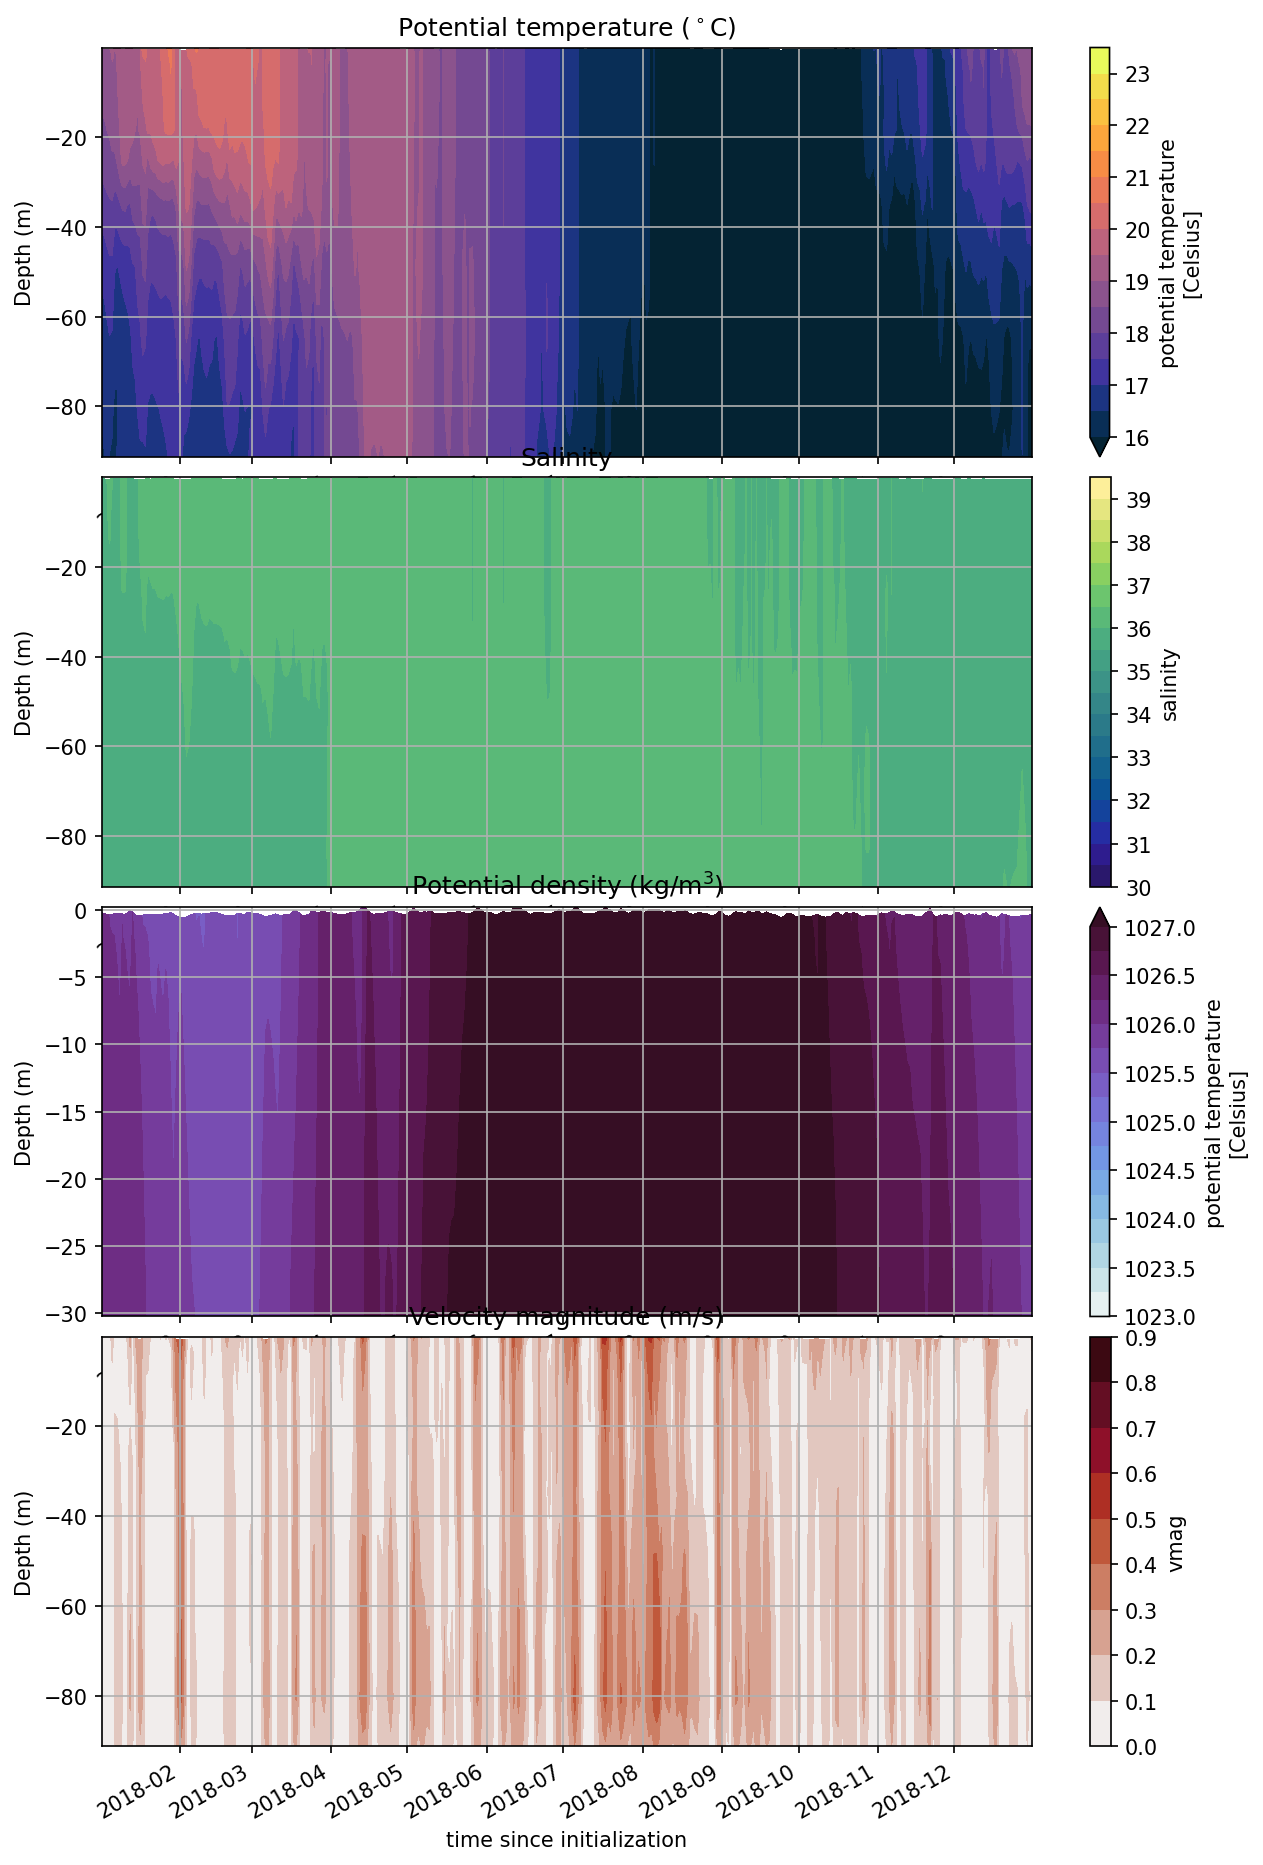

In [107]:
gs = gridspec.GridSpec(nrows=4,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,15],dpi=150)
ax = None

ax = fig.add_subplot(gs[0,0])
ds.temp.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.thermal',levels=np.arange(16,24,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential temperature ($^\circ$C)')

ax = fig.add_subplot(gs[1,0])
ds.salt.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.haline',levels=np.arange(30,40,.5))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Salinity')

ax = fig.add_subplot(gs[2,0])
rho.plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.dense',levels=np.arange(1023,1027.25,.25))
ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Potential density (kg/m$^{3}$)')

ax = fig.add_subplot(gs[3,0])
ds.vmag.isel(eta_rho=eta_station,xi_rho=xi_station).plot.contourf(y='z_rho',x='ocean_time',cmap='cmo.amp',levels=np.arange(0,1,.1))

ax.grid()
ax.set_ylabel('Depth (m)')
ax.set_title('Velocity magnitude (m/s)')

#### Wind stress and Ekman upwelling

In [58]:
omega = 7.29e-5
f = 2 * omega * np.sin(np.deg2rad(ds.lat_rho))
rho0 = 1030
ds['U_ek'] = grid.interp(ds.sustr,'X',boundary='fill') / (rho0 * f)
ds['V_ek'] = -grid.interp(ds.svstr,'Y',boundary='fill') / (rho0 * f)


AttributeError: 'Dataset' object has no attribute 'sustr'

In [ ]:
# now calculate vertical velocities
ds['W_ek'] = grid.interp(grid.diff(ds.U_ek,'X',boundary='fill'),'X',boundary='fill') + grid.interp(grid.diff(ds.V_ek,'Y',boundary='fill'),'Y',boundary='fill')

In [ ]:


gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([135, 139, -36.25, -32.5])
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im = (((ds.W_ek**2).mean(dim='ocean_time'))**0.5).plot(x='lon_rho',y='lat_rho',cmap='cmo.rain', add_colorbar=False,vmin=0,vmax=0.08)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)


ax.text(138.600,-34.9242,'  Adelaide  ',ha='left',va='center'), ax.plot(138.600,-34.9242,marker='x',color='k')
ax.text(138.4674,-34.72596,'   Bolivar  ',ha='left',va='center'), ax.plot(138.4674,-34.72596,marker='x',color='k')
ax.text(138.50393,-34.96313,'   Glenelg  ',ha='left',va='center'), ax.plot(138.50393,-34.96313,marker='x',color='k')
ax.text(138.462347,-35.12587,'   Christies Bch  ',ha='left',va='center'), ax.plot(138.462347,-35.12587,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Upwelling w (m/s)')
ax.set_title('')  

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax.set_extent([138, 138.8, -35.25, -34.5])
feature = ax.add_feature(coastHR, edgecolor='black',facecolor='gray')
im = (((ds.W_ek**2).mean(dim='ocean_time'))**0.5).plot(x='lon_rho',y='lat_rho',cmap='cmo.rain', add_colorbar=False,vmin=0,vmax=.08)     
co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',levels=np.arange(0,220,20),linewidths=0.25)     
ax.clabel(co, co.levels, inline=True, fontsize=10)


ax.text(138.600,-34.9242,'  Adelaide  ',ha='left',va='center'), ax.plot(138.600,-34.9242,marker='x',color='k')
ax.text(138.4674,-34.72596,'   Bolivar  ',ha='left',va='center'), ax.plot(138.4674,-34.72596,marker='x',color='k')
ax.text(138.50393,-34.96313,'   Glenelg  ',ha='left',va='center'), ax.plot(138.50393,-34.96313,marker='x',color='k')
ax.text(138.462347,-35.12587,'   Christies Bch  ',ha='left',va='center'), ax.plot(138.462347,-35.12587,marker='x',color='k')


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Upwelling w (m/s)')
ax.set_title('')  




In [ ]:


gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax = fig.add_subplot(gs[0,0])

ds.W_ek.isel(eta_rho=eta_station,xi_rho=xi_station).plot(x='ocean_time')
ax.axhline(0,color='k',zorder=-10)
ax.grid()
ax.set_ylim(-.06,.06)
ax.set_ylabel('Ekman upwelling (m/s)')
ax.set_title('Ekman upwelling [positive] and downwelling [negative] (m/s)')